In [20]:
import requests
import time
import csv
import matplotlib
import matplotlib.pyplot as plt

In [21]:
BANK_SERVICE_URL = "https://latest-960957615762.me-central1.run.app"
BALANCE_ENDPOINT = f"{BANK_SERVICE_URL}/getbalance"
LOGS_ENDPOINT = f"{BANK_SERVICE_URL}/getlogs"
NUMBER_OF_REQUESTS = 100
REQUEST_TIMEOUT = 10
DELAY_BETWEEN_REQUESTS = 0.1

In [22]:
def invoke(): # invoking the banking service 100 times to generate log data
    print(f"[1/3] Invoking {NUMBER_OF_REQUESTS} times")
    cnt = 0
    
    for i in range(NUMBER_OF_REQUESTS):
        try:
            response = requests.get(BALANCE_ENDPOINT, timeout=REQUEST_TIMEOUT)
            print(f"Request № {i+1} out of {NUMBER_OF_REQUESTS}: Status {response.status_code}")
        except requests.exceptions.RequestException as e:
            print(f"Request № {i+1} out of {NUMBER_OF_REQUESTS}: ERROR: ({type(e).__name__})")
        
        cnt += 1
        time.sleep(DELAY_BETWEEN_REQUESTS)

    print(f"{cnt} Requests are DONE!")

In [23]:
def fetch_logs():
    print("[2/3] Fetching logs...")
    try:
        resp = requests.get(LOGS_ENDPOINT, timeout=10)
        resp.raise_for_status()
        return resp.text
    except Exception as e:
        print(f"Failed to fetch logs: {e}")
        return ""

In [24]:
def parse_logs(log_text):
    """Parse logs to count requests and errors."""
    lines = [line.strip() for line in log_text.strip().split('\n') if line.strip()]
    
    total_requests = sum(1 for line in lines if "Processing GET request" in line)
    errors_500 = sum(1 for line in lines if "ERROR Internal Server Error [500]" in line)
    errors_db = sum(1 for line in lines if "ERROR Database Connection Pool Empty" in line)
    warnings = sum(1 for line in lines if "WARNING Server Latency is" in line)
    
    # Warnings are NOT failures — ignore them for reliability calculation
    failures = errors_500 + errors_db
    successes = max(0, total_requests - failures) # avoiding from negative
    
    return total_requests, errors_500, errors_db, successes, warnings

In [25]:
def save_results(total, successes, errors_500, errors_db, warnings):
    filepath = "results.csv"
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Metric", "Count"])
        writer.writerow(["Total Requests", total])
        writer.writerow(["Successful Requests", successes])
        writer.writerow(["Failures - Internal Server Error (500)", errors_500])
        writer.writerow(["Failures - Database Connection Pool Empty", errors_db])
        writer.writerow(["Warnings - Server Latency", warnings])
        writer.writerow(["Reliability (%)", f"{(successes / total) * 100:.2f}" if total > 0 else "N/A"])
    print(f"Results saved to {filepath}")

In [26]:
def plot_results(successes, errors_500, errors_db, warnings):
    plt.figure(figsize=(6, 6))
    plt.pie(
        [successes, errors_500, errors_db, warnings],
        labels=["Success","Warnings", "Failure - 500", "Failure - DB", ],
        colors=["#4CAF50", "#FFFF00", "#F44336", "#FF7F50"],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Banking Service Reliability")
    plt.tight_layout()
    chart_path = "reliability.png"
    plt.savefig(chart_path)
    print(f"Chart saved to {chart_path}")

In [27]:
def main():
    invoke()
    log_data = fetch_logs()
    if not log_data:
        print("No log data retrieved!")
        return

    total, errors_500, errors_db, successes, warnings = parse_logs(log_data)
    failures = errors_500 + errors_db

    if total == 0:
        print("No 'Processing GET request' lines found in logs.")
        return

    reliability = (successes / total) * 100
    print(f"\n[3/3] RELIABILITY REPORT")
    print(f"Total logged requests:     {total}")
    print(f"Successful responses:      {successes} ({reliability:.1f}%)")
    print(f"Failures (500 errors):     {errors_500}")
    print(f"Failures (DB pool empty):  {errors_db}")
    print(f"Warnings:                  {warnings}")
    print(f"Total failures:            {failures}")

    save_results(total, successes, errors_500, errors_db, warnings)
    plot_results(successes, errors_500, errors_db, warnings)

    print("\nAutomation complete!")

[1/3] Invoking 100 times
Request № 1 out of 100: Status 200
Request № 2 out of 100: Status 200
Request № 3 out of 100: Status 200
Request № 4 out of 100: Status 500
Request № 5 out of 100: Status 200
Request № 6 out of 100: Status 200
Request № 7 out of 100: Status 200
Request № 8 out of 100: Status 200
Request № 9 out of 100: Status 200
Request № 10 out of 100: Status 200
Request № 11 out of 100: Status 200
Request № 12 out of 100: Status 200
Request № 13 out of 100: Status 200
Request № 14 out of 100: Status 200
Request № 15 out of 100: Status 200
Request № 16 out of 100: Status 200
Request № 17 out of 100: Status 200
Request № 18 out of 100: Status 200
Request № 19 out of 100: Status 200
Request № 20 out of 100: Status 200
Request № 21 out of 100: Status 200
Request № 22 out of 100: Status 200
Request № 23 out of 100: Status 200
Request № 24 out of 100: Status 200
Request № 25 out of 100: Status 200
Request № 26 out of 100: Status 200
Request № 27 out of 100: Status 500
Request № 28

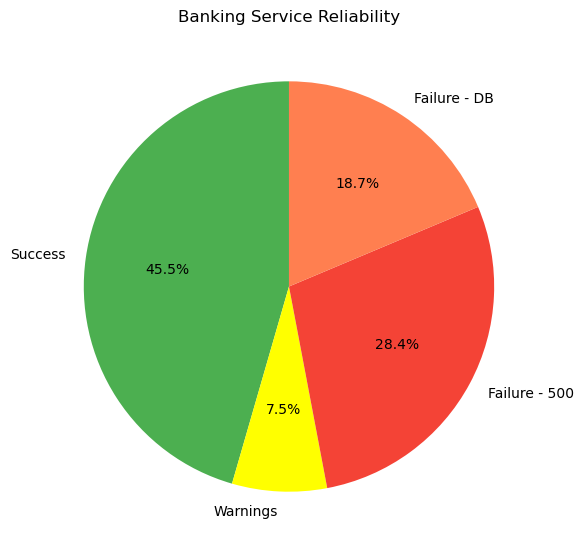

In [28]:
if __name__ == "__main__":
    main()